In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
data = pd.read_csv('Data/gen.us.txt')['Close'].values
data2 = pd.read_csv('Data/amzn.us.txt')['Close'].values

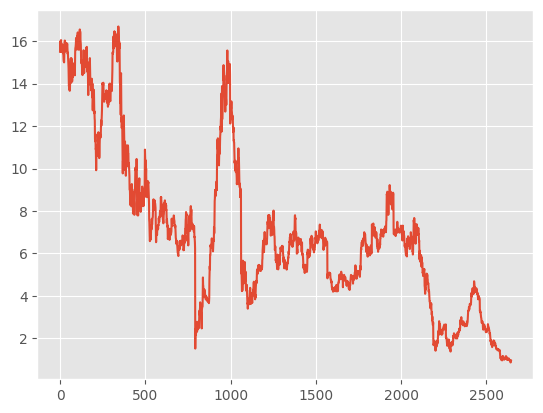

In [3]:
plt.plot(data)
# plt.plot(data2)

plt.show()

In [4]:
data = np.log1p(data)
data2 = np.log1p(data2)

In [5]:
data.shape

(2645,)

In [6]:
scaler = MinMaxScaler((0, 1))

data = scaler.fit_transform(data.reshape(-1, 1)).T[0]
data2 = scaler.fit_transform(data2.reshape(-1, 1)).T[0]

In [7]:
data2 = data2[:len(data)]

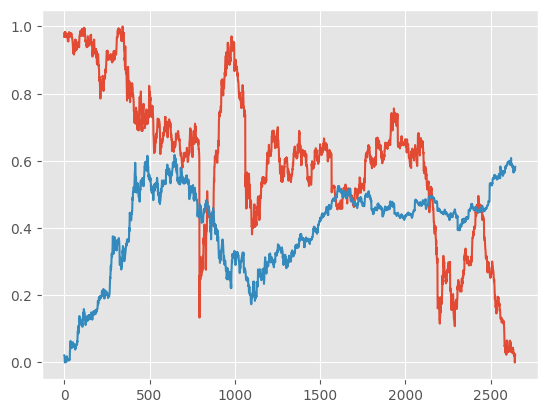

In [8]:
plt.plot(data)
plt.plot(data2)
plt.show()

In [9]:
data_tensor = torch.FloatTensor(np.vstack([data, data2]))
data0 = data_tensor[0]

In [10]:
data_tensor

tensor([[0.9690, 0.9797, 0.9823,  ..., 0.0000, 0.0196, 0.0226],
        [0.0209, 0.0197, 0.0155,  ..., 0.5743, 0.5740, 0.5823]])

In [11]:
def create_setA(data: np.array) -> torch.Tensor:
    set_A = torch.zeros(len(data), len(data))
    k = 1
    for i in range(len(data)):
        set_A[i, :k] = torch.FloatTensor(data[:k])
        k += 1
    
    return set_A

In [12]:
set_A = torch.stack(list(map(lambda x: create_setA(x), data)))

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
# set_A = create_setA(data)

## Data Preparation

In [333]:
n = 300
dt = 1/n

# data = dclProcess(n, 10).T
data = np.array([merton_process(s0=1, xiP=7, muj=0, sigmaj=0.2, r=0.04, sigma=0.6, n=n, T=1) for i in range(10)])
# data = np.array([geometric_BM(s0=1, mu=0.1, sigma=0.5, n=n, T=1) for i in range(10)])

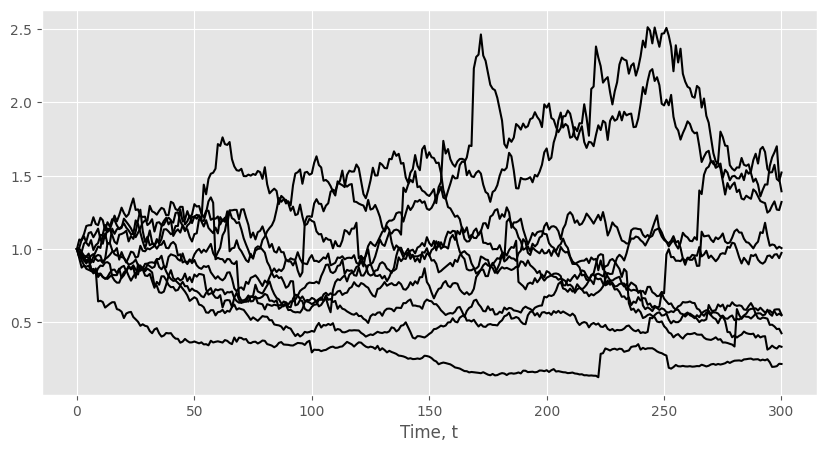

In [334]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T, color='black')

plt.xlabel('Time, t')
plt.show()

In [335]:
# data_array = []
# for i in data:
#     scaler = MinMaxScaler((0, 1))
#     data_array.append(scaler.fit_transform(i.reshape(-1, 1)).T)
    
# data_array = np.array(data_array)

In [336]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [337]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

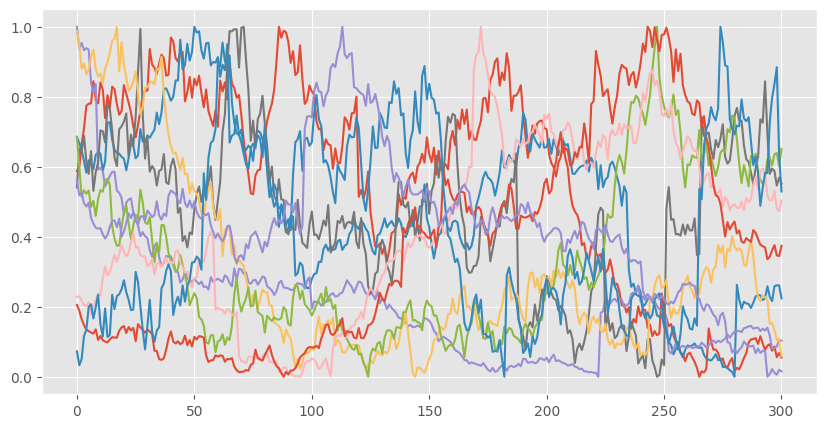

In [338]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data_tensor.T)
plt.show()

In [493]:
mu = 0.0
x0 = 0.0
theta = 5
sigma = 1
times = np.linspace(1/300, 1, 301)

In [494]:
cov_matrix = []
for i in range(n+1):
    row = []
    for j in range(n+1):
        row.append(sigma**2 / (2*theta) * (np.exp(-theta * np.abs(times[i]-times[j])) - np.exp(-theta * (times[i]+times[j]))))
        
    cov_matrix.append(row)
    
cov_matrix = torch.FloatTensor(cov_matrix)

In [495]:
mu_vector = torch.FloatTensor([mu + (x0 - mu) * torch.exp(torch.tensor(-theta * times[i])) for i in range(n+1)])

In [540]:
p_Z = MultivariateNormal(mu_vector, cov_matrix)
z = p_Z.rsample(sample_shape=(10,))

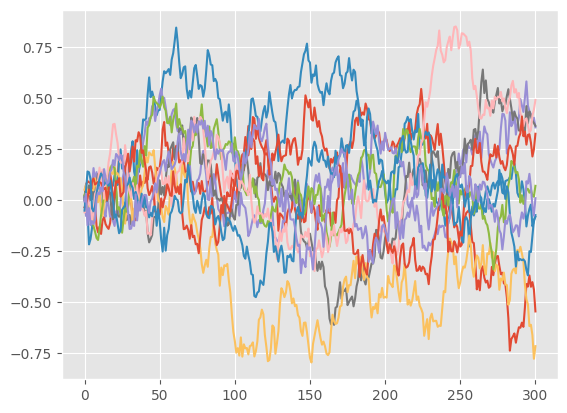

In [541]:
plt.plot(z.T)
plt.show()

In [542]:
p_Z.log_prob(z)

tensor([438.4890, 421.5410, 443.6679, 446.2133, 421.7152, 450.4806, 451.1707,
        443.1069, 454.0583, 423.8746])

In [543]:
ou_sample = torch.FloatTensor(ornstein_uhlenbeck_process(300, 10, mu=mu, theta=theta, sigma=sigma, x0=x0))

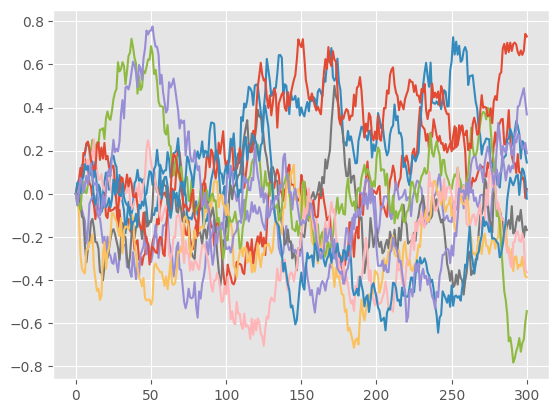

In [544]:
plt.plot(ou_sample.T)
plt.show()

In [545]:
p_Z.log_prob(ou_sample)

tensor([426.6284, 403.6569, 444.7096, 427.4502, 429.3710, 433.4276, 424.4809,
        425.9617, 449.4755, 439.5840])

## Identify jump intensity

In [33]:
idx_jumps = list(map(lambda x: find_jumps(x, 1), data_tensor))

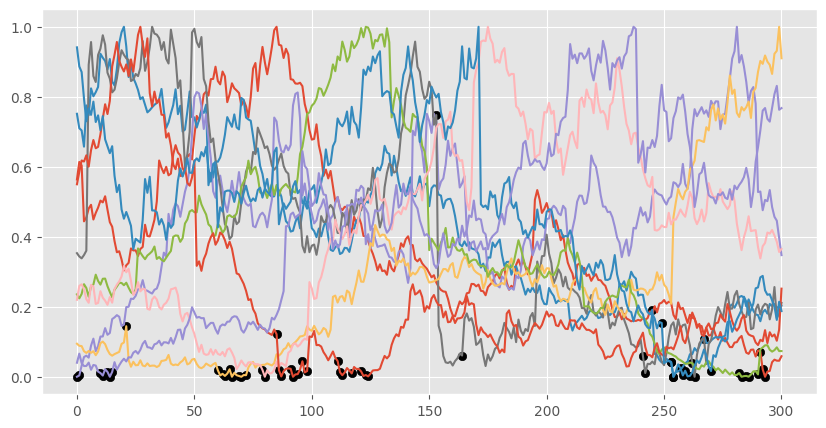

In [34]:
plot_jumps(data_tensor, idx_jumps)

In [35]:
calc_mean_jump(data_tensor, idx_jumps)

tensor(0.0356)

In [36]:
init_intensity = estimate_init_intensity_array(data_tensor, idx_jumps)/dt
init_intensity

array([ 2.99003322,  2.99003322,  1.99335548,  6.97674419,  8.97009967,
        4.9833887 ,  1.99335548, 14.95016611,  7.97342193,  4.9833887 ])

In [37]:
jump_part, diff_part = separate_dynamics(data_tensor, idx_jumps)
init_params = estimate_init_params(data_tensor, jump_part, diff_part, dt)
# likelihood_mjd(log_return(data_tensor[0]), init_params[0], init_intensity[0], dt)

In [38]:
opt_params = optimize_params(data_tensor, init_params, init_intensity, dt)

In [39]:
xiP0 = opt_params[-1]
xiP0

5.880398671096346

## Signature Examples

In [42]:
signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature = signature_set(signature_traj)[1:]

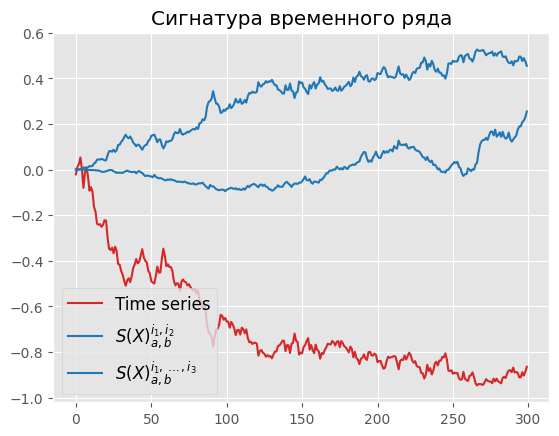

In [43]:
plt.plot(signature_traj[1][0], color='tab:red', label='Time series')
plt.plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
plt.plot(signature_traj[3][2], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
# plt.plot(signature_traj[6][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_6}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')

plt.legend(fontsize=12, loc=3)
plt.title('Сигнатура временного ряда')
plt.show()

## Train model

In [619]:
class DiffMap(nn.Module):
    def __init__(self, time_steps, h_dim, latent_dim, dt, permute):

        super(DiffMap, self).__init__()
    
        # self.out_size = out_size
        
        self.h_dim = h_dim
        self.laten_dim = latent_dim
        self.time_steps = time_steps
        self.dt = dt
        # self.hidden_lp = 2**5
        hidden = 2**7
        self.v_dim = latent_dim
        self.d = h_dim // 2
        self.permute = permute
        
        # self.drift = Drift(self.v_dim)
        # self.diffusion = Diffusion(self.v_dim, 1)
        # self.jump = Jump(self.v_dim)
        # self.xiP = nn.Parameter(torch.rand(1))
        
        
        self.in_size = self.d
        self.out_size = self.h_dim - self.d
    
        if self.permute:
            self.in_size, self.out_size = self.out_size, self.in_size
        
        
        self.fc_mu = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=2, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_sig = nn.Sequential(
            nn.LSTM(self.in_size, self.in_size, num_layers=2, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.in_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.out_size)
        )
        self.fc_nu = nn.Sequential(
            nn.LSTM(self.out_size, self.out_size, num_layers=2, batch_first=True),
            extract_tensor(),
            nn.Sigmoid(),
            nn.Linear(self.out_size, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, hidden),
            nn.Sigmoid(),
            nn.Linear(hidden, self.in_size)
        )
        
        # self.xi = Operator_F(self.time_steps, self.out_size)
        # self.psi = Operator_F(self.h_dim, self.h_dim)
        # self.time_grid = torch.FloatTensor(np.cumsum(np.zeros(self.v_dim) + 1/self.v_dim))
        
        # self.h_dim_v = 1
        # self.z_dim = 30
        # self.phi = Phi(self.z_dim, 1, 1)
        # self.mu_v = Mu_V(1, self.h_dim_v, h_dim)
        # self.sigma_v = Sigma_V(1, self.h_dim_v, h_dim)

        
        self.base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
        # self.base_dist = MultivariateNormal(mu_vector, cov_matrix)

    def forward(self, x):
        
        x1, x2 = x[:, :self.d], x[:, self.d:]
        
        if self.permute:
            x2, x1 = x1, x2
        
        z1 = x1 + self.fc_nu(x2)
        sig = self.fc_sig(z1)
        
    
        z2 = self.fc_mu(z1) + x2 * torch.exp(sig)
        
        if self.permute:
            z2, z1 = z1, z2
 
        z = torch.cat([z1, z2], axis=1)

        log_pz = self.base_dist.log_prob(z)
        log_jacob = sig.sum(-1)
        
        return z, log_pz, log_jacob

    def inverse(self, z):
    
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        if self.permute:
            z2, z1 = z1, z2
            
        
        x2 = (z2 - self.fc_mu(z1)) * torch.exp(-self.fc_sig(z1))
        x1 = z1 - self.fc_nu(x2)
      
        
        if self.permute:
            x2, x1 = x1, x2
        
        x = torch.cat([x1, x2], axis=1)

        return x




class Flow(nn.Module):
    def __init__(self, n_flows, h_dim, latent_dim, time_steps, dt, sig_dim, xiP0):
        super(Flow, self).__init__()
        
        self.h_dim = h_dim
        self.permute = [True if i % 2 else False for i in range(n_flows)]

        self.bijections = nn.ModuleList(
            [DiffMap(time_steps, h_dim, latent_dim, dt, self.permute[i]) for i in range(n_flows)]
        )
        
        
        # self.xiP = nn.Parameter(torch.tensor(xiP0), requires_grad=True)
        # self.fc_xi = nn.Sequential(nn.Linear(10, 2**6), nn.ReLU(), nn.Linear(2**6, 1))
        # self.xiP0 = xiP0
        self.xiP = xiP0
        
        self.time_steps = time_steps
        self.dt = dt
        self.v_dim = latent_dim
        self.psi = Operator_F(self.time_steps, self.h_dim)
        self.zeta = Operator_F(self.h_dim, self.h_dim)
        
        self.drift = Drift(self.v_dim)
        self.diffusion = Diffusion(self.v_dim, 1)
        self.jump = Jump(self.v_dim)
        self.phi = Phi(self.v_dim, 10, 10)
        self.sigmoid_sig = nn.Sigmoid()
        
        
        self.fc_signature = nn.Sequential(nn.Linear(sig_dim, 2**7), nn.Sigmoid())

    def forward(self, x):
        log_jacobs = []
        
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
        # self.xiP = torch.abs(self.fc_xi(x[:, 0].view(1, -1)).squeeze(0).squeeze(0))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        x = self.non_linearity * x + self.zeta(self.non_linearity)

        for bijection in self.bijections:
            
            # wt = torch.randn((1, self.v_dim))
            # v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
            # # self.xiP = torch.abs(self.fc_xi(x[:, 0].view(1, -1)).squeeze(0).squeeze(0))
            # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
            
            # self.non_linearity = torch.exp(-self.psi(vt.T))
            # x = self.non_linearity * x + self.zeta(self.non_linearity)

            x, log_pz, lj = bijection(x)

            log_jacobs.append(lj)

        return x, log_pz, sum(log_jacobs), v0

    def inverse(self, z):

        for bijection in reversed(self.bijections):
            z = bijection.inverse(z)
            
        
        wt = torch.randn((1, self.v_dim))
        v0 = self.phi(wt, z[:, 0].view(1, z.size(0)))
        # self.xiP = torch.abs(self.fc_xi(z[:, 0].view(1, -1)).squeeze(0).squeeze(0))
        vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
        self.non_linearity = torch.exp(-self.psi(vt.T))
        z = (z - self.zeta(self.non_linearity)) / self.non_linearity


        return z
    
    def fit(self, X, epochs=800, learning_rate=1e-3):
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.99)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[500, 900], gamma=0.3)
        self.x_mean = torch.mean(X, dim=0)
        self.x_std = torch.std(X, dim=0)

        losses = []
        softmax = nn.Softmax()
        mse = nn.MSELoss()
        kl = nn.KLDivLoss()
        epochs = tqdm(range(epochs))

        for _ in epochs:
            _, log_pz, log_jacob, v0 = self.forward(X)
            
            # z = torch.FloatTensor(ornstein_uhlenbeck_process(self.h_dim - 1, self.v_dim, mu=0.0, theta=5, sigma=0.3, x0=0.0))
            
            p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
            z = p_Z.rsample(sample_shape=(X.size(0),))
            synth_x = self.inverse(z)
    
            signature = (stack_signatures(compute_path_signature_torch(synth_x, level_threshold=2)[1:]))
            signature_true = (stack_signatures(compute_path_signature_torch(X, level_threshold=2)[1:]))
            
            loss_likelihood = (-log_pz - log_jacob).mean()
            loss_sig = mse(signature, signature_true)
            loss_init_values = torch.mean((X[:, 0] - synth_x[:, 0])**2)
            # loss_intensity = (self.xiP - self.xiP0)**2
        
        
            loss = loss_likelihood + loss_init_values
            # + 0.0001 * loss_sig
            # + 0.01 * loss_sig
            # + loss_sig
            

            optim.zero_grad()
            loss.backward()
            optim.step()
            scheduler.step()

            epochs.set_description(f'Loss: {round(loss.item(), 4)}')
            losses.append([loss_likelihood.item(), loss_init_values.item(), loss_sig.item()])
            
        return np.array(losses)
            
    
    def sample(self, n_samples):
        samples_array = []
        for i in range(n_samples):
            p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
            # p_Z = MultivariateNormal(mu_vector, cov_matrix)
            z = p_Z.rsample(sample_shape=(self.v_dim,))

            X_sample = self.inverse(z).detach().numpy()
            samples_array.append(X_sample)

        return samples_array

In [620]:
# data_tensor = data_tensor.view(1, -1)

In [621]:
data_tensor.size()

torch.Size([10, 301])

In [622]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
time_steps = 10
dt = torch.FloatTensor([1/time_steps])
# n = data_tensor.size(0)
sig_dim = n + n**2 
# + n**3

In [623]:
# nsde_flow = Flow(128, 10, h_dim, h_dim)
n_flows = 8

nsde_flow = Flow(n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=800)

Loss: -1066.5837: 100%|██████████| 800/800 [03:09<00:00,  4.22it/s]


In [624]:
nsde_flow.eval()

Flow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): LSTM(150, 150, num_layers=2, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(150, 150, num_layers=2, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_nu): Sequential(
        (0): LSTM(151, 151, num_layers=2, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_

In [625]:
# u = nsde_flow.forward(data_tensor)[0].detach()

In [631]:
samples = nsde_flow.sample(1)[0]
# samples = samples[(~(np.max(samples, axis=1) > 1.5*np.max(data))) & (~(np.min(samples, axis=1) < 1.5*np.min(data)))]

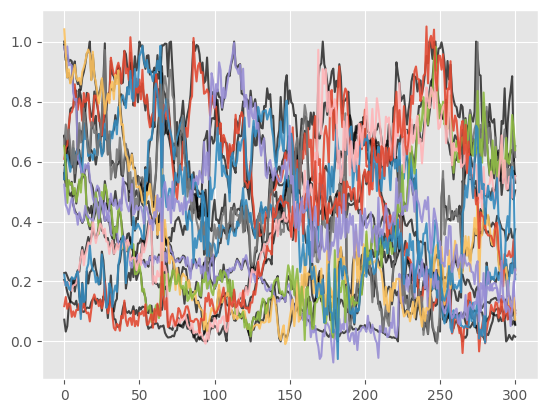

In [632]:
plt.plot(data_tensor.T, color='black', alpha=0.7, label='Real')
plt.plot(samples[:, :].T, alpha=0.9, label='Synth')

# plt.legend()
plt.show()

In [633]:
# fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

# plt.plot(data_tensor.T, color='black', alpha=0.6, label='Real')
# plt.plot(samples.T, alpha=0.9, label='Synth')

# handles, labels = ax.get_legend_handles_labels()
# fig.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')

# # plt.legend()
# plt.ylabel('Values')
# plt.xlabel('Time')

# plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth.pdf', dpi=300)
# plt.show()

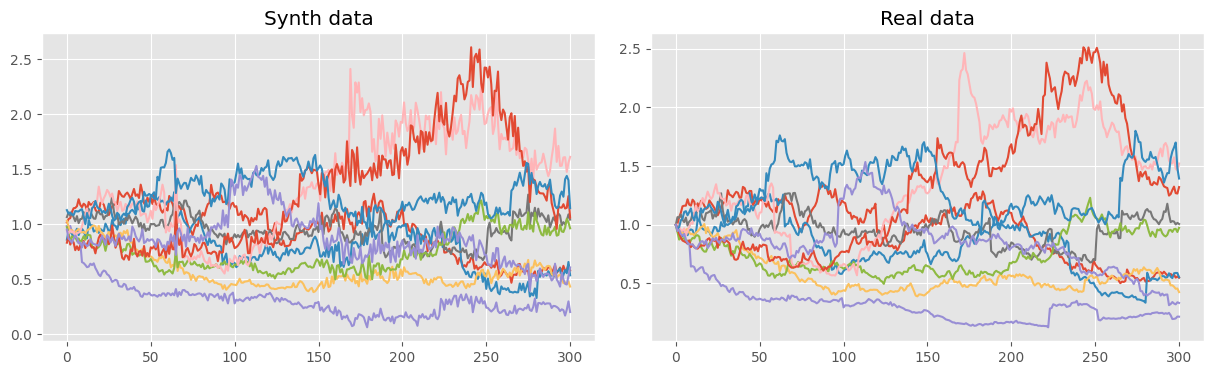

In [634]:
synth_data = scaler.inverse_transform(samples.T).T
# synth_data = samples.T
real_data = scaler.inverse_transform(data.T).T
# data_rescale = data.T

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data.T)
axs[0].set_title('Synth data')

axs[1].plot(real_data.T)
axs[1].set_title('Real data')
# axs[1].legend()

plt.subplots_adjust(wspace=0.1)
plt.show()

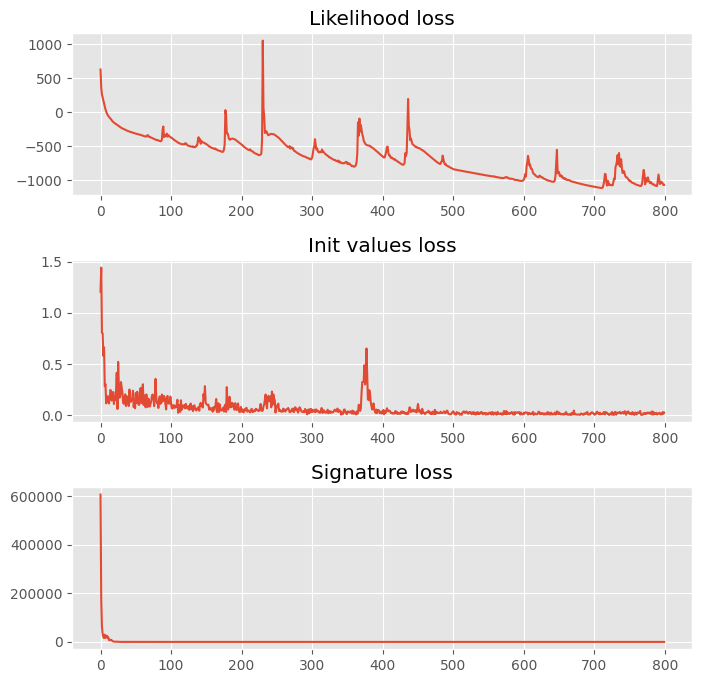

In [635]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(losses.T[0])
axs[0].set_title('Likelihood loss')

axs[1].plot(losses.T[1])
axs[1].set_title('Init values loss')

axs[2].plot(losses.T[2])
axs[2].set_title('Signature loss')

plt.subplots_adjust(hspace=0.4)
plt.show()

## Evaluate

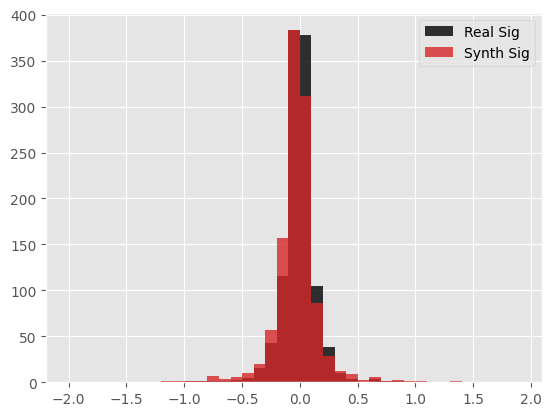

In [636]:
signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
signature = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature_real = signature_set(signature_traj)[1:]

plt.hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real Sig', color='black', alpha=0.8)
plt.hist(signature, bins=np.arange(-2, 2, 0.1), label='Synth Sig', color='tab:red', alpha=0.8)

plt.legend()
plt.show()

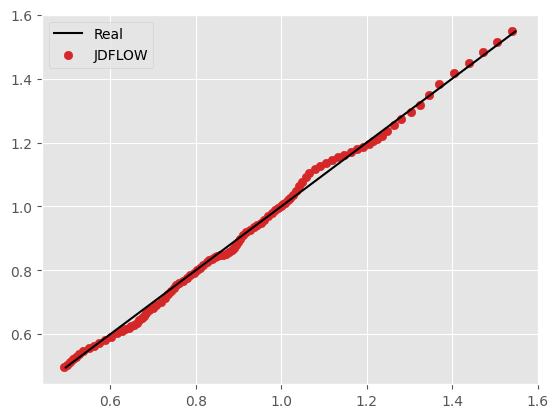

In [637]:
# plt.plot(np.arange(2), label='Real', color='black')

plt.plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
plt.scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:red', label='JDFLOW')


plt.legend()
plt.show()

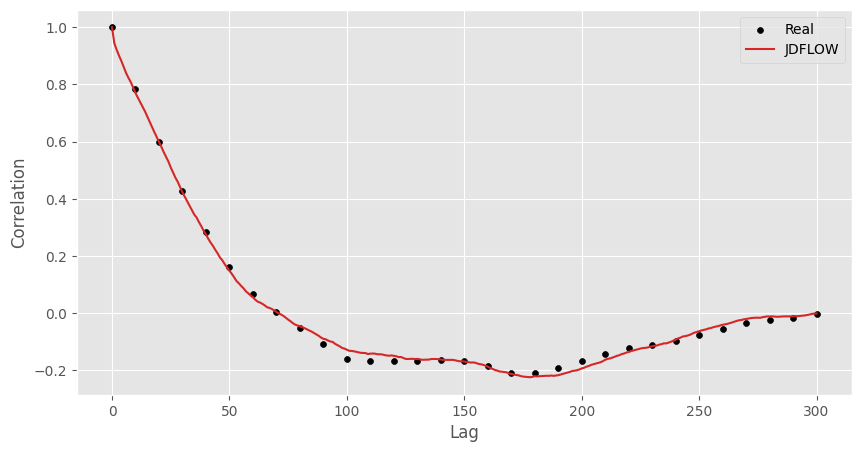

In [638]:
plt.subplots(figsize=(10,5), dpi=100)

plt.scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
plt.plot(autocorr_vec(synth_data), label = 'JDFLOW', color='tab:red')


plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()
plt.xticks()
plt.yticks()
# plt.savefig(f'Autocorr_{name}.pdf', dpi=300) #save figure
plt.show()

In [ ]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

n = 31
test_size = 60
train_size_init = int(len(data) - n*test_size)

def forecasting_cv(synth, real, train_size_init, test_size, n):
    array_mse = []
    train = synth[:train_size_init]
    train_size = train_size_init

    for i in range(n):
        df = pd.DataFrame()
        df['y'] = train
        df.index = pd.date_range(start='1/1/2022', periods=len(train), freq='D')
        df = df.reset_index()
        df = df.rename(columns={'index': 'ds'})

        m = Prophet(daily_seasonality=True)
        m.fit(df)
        
        future = m.make_future_dataframe(periods = test_size)
        pred_synth = m.predict(future)['yhat'][-test_size:]
        
        test_synth = synth[train_size : (train_size+test_size)]
        test_real = real[train_size : (train_size+test_size)]
        
        mse = mean_squared_error(pred_synth.values, test_real)
        
        train = np.concatenate([train, test_synth])
        
        train_size += test_size
        
        array_mse.append(mse)
        
    return array_mse

In [524]:
drift = Drift(h_dim)
diffusion = Diffusion(h_dim, 1)
jump = Jump(h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=1e-3)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=1e-3)
optim_jump = optim.Adam(jump.parameters(), lr=1e-3)
scheduler_drift = optim.lr_scheduler.MultiStepLR(optim_drift, milestones=[20], gamma=0.3)
scheduler_diffusion = optim.lr_scheduler.MultiStepLR(optim_diffusion, milestones=[20], gamma=0.3)
scheduler_jump = optim.lr_scheduler.MultiStepLR(optim_jump, milestones=[20], gamma=0.3)

epochs_j = tqdm(range(40))
loss_array_j = []
mse_j = nn.MSELoss()

base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))
z = u[0].view(1, -1)
xiP = 30

for _ in epochs_j:  
    # z = base_dist.rsample((10, ))
    
    # xiP = xi()
    
    x = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, xiP)
    # inv_sol = sdeint_jump_inverse(drift, diffusion, jump, dt, x.detach(), time_steps, h_dim).detach()
    sol = x
    
    loss_v = mse_j(sol, u) + torch.mean((sol[0] - u[0])**2)
    
    # for dp in drift.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in diffusion.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    # for dp in jump.parameters():
    #     dp.data.clamp_(-0.05, 0.05)
        
    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_xi.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_xi.step()
    
    scheduler_drift.step()
    scheduler_diffusion.step()
    scheduler_jump.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())


Loss: 0.11530408263206482: 100%|██████████| 40/40 [04:04<00:00,  6.10s/it]


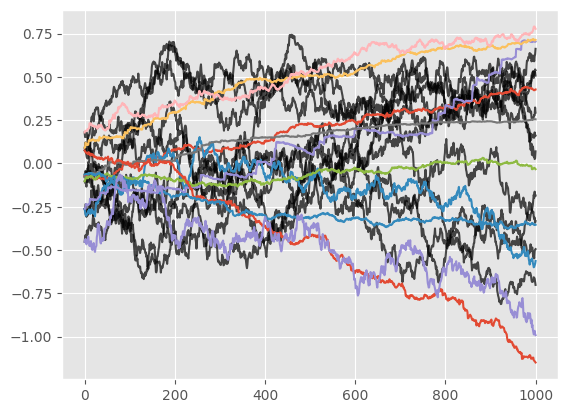

In [529]:
sol = sdeint_jump(drift, diffusion, jump, dt, z, time_steps, h_dim, 30)

plt.plot(u, alpha=0.7, color='black')
plt.plot(sol.detach().numpy())

plt.show()

## NSDE for each record

In [66]:
u = data_tensor.T
h_dim = len(u[0])
time_steps = h_dim
dt = torch.FloatTensor([1/time_steps])

drift = Drift(1)
diffusion = Diffusion(1, 1)
jump = Jump(1)
f = Operator_F(h_dim, h_dim)

optim_drift = optim.Adam(drift.parameters(), lr=3e-4)
optim_diffusion = optim.Adam(diffusion.parameters(), lr=3e-4)
optim_jump = optim.Adam(jump.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)

In [67]:
# h_dim

10

In [430]:
epochs_j = tqdm(range(10))
loss_array_j = []
mse_j = nn.MSELoss()

for _ in epochs_j:  
    sol = torch.stack(sdeint_jump_1d(drift, diffusion, jump, dt, u[:, 0].view(-1, 1), time_steps)).squeeze(-1).T
    
    loss_v = mse_j(f(sol), u)

    
    optim_drift.zero_grad()
    optim_diffusion.zero_grad()
    optim_jump.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_drift.step()
    optim_diffusion.step()
    optim_jump.step()
    optim_f.step()
    
    epochs_j.set_description(f'Loss: {loss_v.item()}')
    loss_array_j.append(loss_v.item())

Loss: 0.1502450555562973: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


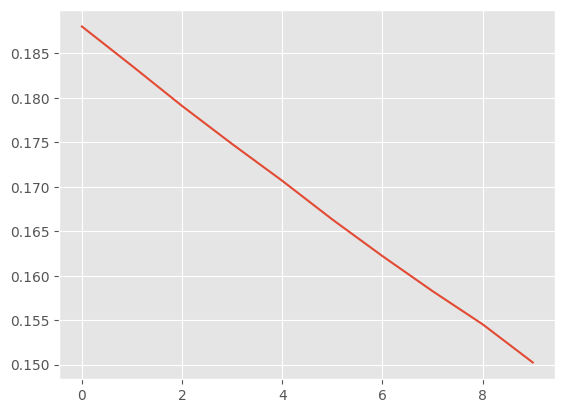

In [431]:
plt.plot(loss_array_j)
plt.show()

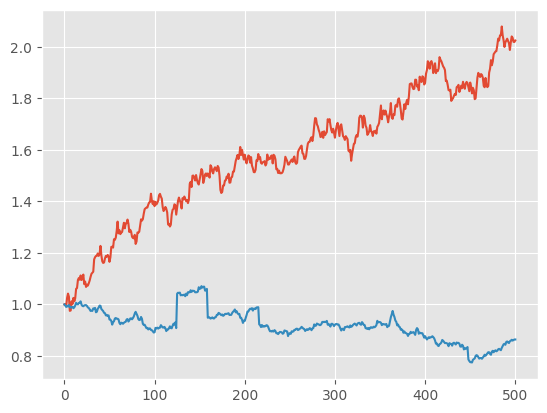

In [435]:
plt.plot(sol.detach().numpy().T)
plt.plot(u[0])
plt.show()

In [201]:
# data_tensor = data_tensor.view(1, -1)

## NSDE

In [204]:
# u = data_tensor
# h_dim = len(u[0])
# time_steps = 50
# dt = torch.FloatTensor([1/time_steps])

# nsde = NSDE(h_dim, dt, time_steps)

# nsde.fit(u, epochs=100)

# s_tilde = nsde.sample(10)


# plt.plot(u.T, color='black')
# plt.plot(s_tilde.T, '--')

# plt.show()

## NSDE VAE

In [25]:
u = data_tensor
h_dim = len(u[0])
data_dim = len(data_tensor[0])
time_steps = 50
dt = torch.FloatTensor([1/time_steps])

set_A = torch.stack(list(map(lambda x: create_setA(x), u)))


h_dim_v = 1
z_dim = 30
data_dim = len(data_tensor[0])

phi = Phi(z_dim, 1, 1)
mu_v = Mu_V(1, h_dim_v, data_dim)
sigma_v = Sigma_V(1, h_dim_v, data_dim)
f = Operator_F(h_dim, h_dim)

optim_phi = optim.Adam(phi.parameters(), lr=3e-4)
optim_mu_v = optim.Adam(mu_v.parameters(), lr=3e-4)
optim_sigma_v = optim.Adam(sigma_v.parameters(), lr=3e-4)
optim_f = optim.Adam(f.parameters(), lr=3e-4)


epochs_v = tqdm(range(100))
loss_array_v = []
mse_v = nn.MSELoss()

In [38]:
for _ in epochs_v:  
    v_array = torch.zeros(size=(u.size(0), h_dim, 1))

    for i in range(u.size(0)):
        u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
        v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
        v_array[i] = v_sol
        
    v_array = v_array.squeeze(2)
    
    v_array = f(v_array)
    
    
    loss_v = mse_v(v_array, u) + torch.mean((u0 - u[:, 0])**2)
    
    optim_phi.zero_grad()
    optim_mu_v.zero_grad()
    optim_sigma_v.zero_grad()
    optim_f.zero_grad()
    
    loss_v.backward()
    
    optim_phi.step()
    optim_mu_v.step()
    optim_sigma_v.step()
    optim_f.step()
    
    epochs_v.set_description(f'Loss: {loss_v.item()}')
    loss_array_v.append(loss_v.item())

Loss: 0.10696950554847717: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


In [39]:
v_array = torch.zeros(size=(u.size(0), h_dim, 1))

for i in range(u.size(0)):
    u0 = phi(torch.randn(size=(u.size(0), z_dim)), u[:, 0].view(-1, 1))
    v_sol = sdeint_V(mu_v, sigma_v, dt, u0[i], h_dim, h_dim_v, set_A[i])
    v_array[i] = v_sol
    
v_array = v_array.squeeze(2).detach().cpu().numpy()


plt.plot(v_array.T)
plt.plot(u.T, color='black')
plt.show()

In [438]:
nsde_vae = NSDE_VAE(h_dim, time_steps, dt)
# 20*2001 u.size(0) *
loss_array, loss_array_v, logvar_array = nsde_vae.fit(u, set_A, u[:, 0].view(-1, 1), epochs=200)

samples = nsde_vae.sample(13, set_A, u[:, 0].view(-1, 1))[:, 0, :]

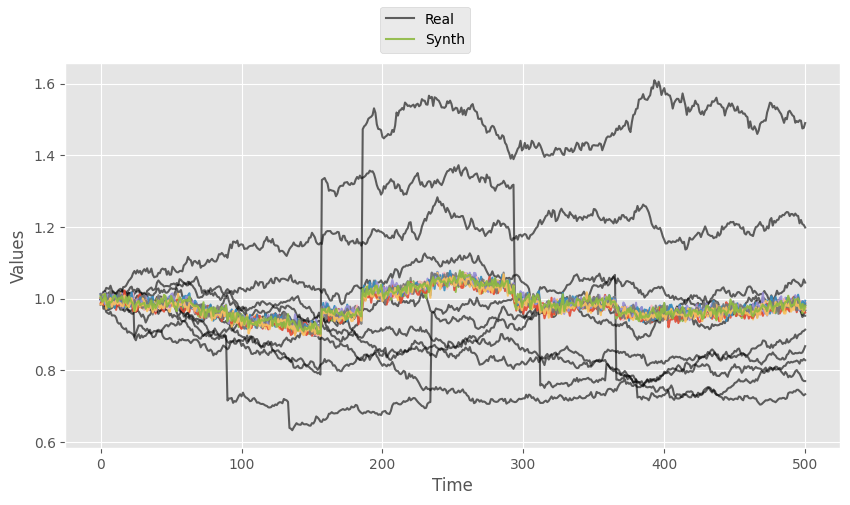

In [488]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(u.T, color='black', alpha=0.6, label='Real')
plt.plot(samples.T, alpha=0.9, label='Synth')

handles, labels = ax.get_legend_handles_labels()
fig.legend([handles[0], handles[-1]], [labels[0], labels[-1]], loc='upper center')

# plt.legend()
plt.ylabel('Values')
plt.xlabel('Time')
plt.show()

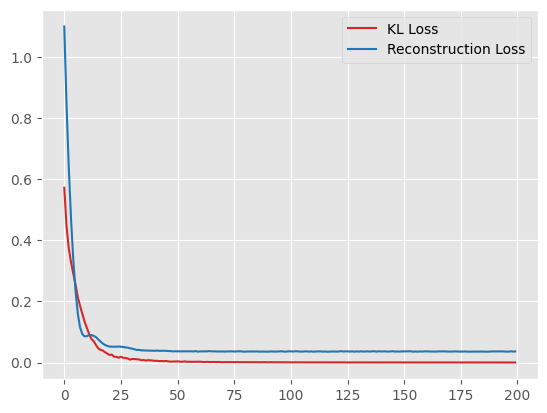

In [492]:
loss_array = np.array(loss_array).T

plt.plot(loss_array[0], color='tab:red', label='KL Loss')
plt.plot(loss_array[1], color='tab:blue', label='Reconstruction Loss')
# plt.plot(loss_array_v, color='green', label='Loss $V(t)$')

plt.legend()
plt.show()